In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
Organoid_Names = ['LAX7_1_MAP2.xls',
                  'LAX7_2_MAP2.xls', 
                  'LAX7_3_MAP2.xls',
                  'LAX7R_1_MAP2.xls',
                  'LAX7R_2_MAP2.xls',
                  'LAX7R_3_MAP2.xls']

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['LAX7_1_CFSE.xls',
                'LAX7_2_CFSE.xls', 
                'LAX7_3_CFSE.xls',
                'LAX7R_1_CFSE.xls',
                'LAX7R_2_CFSE.xls',
                'LAX7R_3_CFSE.xls']

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 14080 / 12544
[Open3D DEBUG] #   Got kernel density: 0.00338697 (s), 289.422 (MB) / 289.422 (MB) / 289 (MB)
[Open3D DEBUG] #     Got normal field: 0.0350490 (s), 292.688 (MB) / 292.688 (MB) / 292 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.953770e-06 / 2.750908e-02
[Open3D DEBUG] #       Finalized tree: 0.0301752 (s), 299.941 (MB) / 299.941 (MB) / 299 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.042784 (s), 301.488 (MB) / 301.488 (MB) / 301 (MB)
[Open3D DEBUG] #Set point constraints: 0.00481009 (s), 302.281 (MB) / 302.281 (MB) / 302 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 192291 / 214152 / 5609
[Open3D DEBUG] Memory Usage: 302.281 MB
[Open3D DEBUG] # Linear system solved: 0.129043 (s), 307.457 (MB) / 307.457 (MB) / 307 (MB)
[Open3D DEBUG] Got average: 0.00401306 (s), 307.938 (MB) / 307.938 (MB) / 307 (MB)
[Open3D DEBUG] Iso-Value: 5.065401e-01 = 7.132084e+03 / 1.408000e+04
[Open3D DEBUG] #          Total Solve:      

setting thread affinity failed


[Open3D DEBUG] Input Points / Samples: 20259 / 17374/ Solved in:  0.001 /  0.010 /  0.007	(351.840 MB)	Nodes: 35937
          GS: 8.4556e-02 -> 8.4556e-02 -> 7.7446e-04 (9.2e-03) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(351.844 MB)	Nodes: 2112
            GS: 7.0066e-02 -> 7.0066e-02 -> 2.1801e-04 (3.1e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.001	(351.844 MB)	Nodes: 3152
              GS: 4.8916e-02 -> 4.8916e-02 -> 3.7494e-04 (7.7e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.003	(351.867 MB)	Nodes: 4912
                GS: 3.2073e-02 -> 3.2073e-02 -> 3.8819e-04 (1.2e-02) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.002 /  0.003	(351.867 MB)	Nodes: 2648
                  GS: 2.0517e-02 -> 2.0517e-02 -> 1.6495e-03 (8.0e-02) [8]
Cycle[0] Depth[10/10]:	Updated constraints / Got syst

[Open3D DEBUG] # Linear system solved: 0.242375 (s), 466.582 (MB) / 466.582 (MB) / 466 (MB)
[Open3D DEBUG] Got average: 0.00435519 (s), 466.766 (MB) / 466.766 (MB) / 466 (MB)
[Open3D DEBUG] Iso-Value: 5.037410e-01 = 1.250336e+04 / 2.482100e+04
[Open3D DEBUG] #          Total Solve:       1.5 (s),     477.3 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 650 / 595
[Open3D DEBUG] #   Got kernel density: 0.000904083 (s), 496.535 (MB) / 496.535 (MB) / 496 (MB)
[Open3D DEBUG] #     Got normal field: 0.00232291 (s), 496.535 (MB) / 496.535 (MB) / 496 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.874820e-05 / 1.868633e-02
[Open3D DEBUG] #       Finalized tree: 0.0110450 (s), 496.535 (MB) / 496.535 (MB) / 496 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0290449 (s), 496.535 (MB) / 496.535 (MB) / 496 (MB)
[Open3D DEBUG] #Set point constraints: 0.00168300 (s), 496.535 (MB) / 496.535 (MB) / 496 (MB)
[Open3D 

Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(446.664 MB)	Nodes: 4913
        GS: 7.8780e-02 -> 7.8780e-02 -> 6.2456e-04 (7.9e-03) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.012 /  0.015	(446.664 MB)	Nodes: 35937
          GS: 7.8147e-02 -> 7.8147e-02 -> 4.8576e-04 (6.2e-03) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(446.664 MB)	Nodes: 1880
            GS: 7.7882e-02 -> 7.7882e-02 -> 2.2392e-04 (2.9e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.001	(446.664 MB)	Nodes: 2448
              GS: 4.4334e-02 -> 4.4334e-02 -> 2.3650e-04 (5.3e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(446.664 MB)	Nodes: 2664
                GS: 2.1939e-02 -> 2.1939e-02 -> 3.4488e-05 (1.6e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / S

In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
display(df)

,Entity,Distance to Surface (μm)
0,A,12.044716
1,A,5.572272
2,A,0.932012
3,A,0.022607
4,A,1.137290
...,...,...
7351,F,NaN
7352,F,NaN
7353,F,NaN
7354,F,NaN


In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'

df['Entity'] = df['Entity'].replace({
              'A':'Initial',
              'B':'Initial',
              'C':'Initial',
              'D':'Relapse',
              'E':'Relapse',
              'F':'Relapse'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]
display(df_final)

#df_filtered below filters for measurements above 10μm
df_filtered = df_final[df_final['Distance to Surface (μm)'] > 10]
df_filtered.to_excel("df_filtered.xlsx", sheet_name='filtered')

#Below are lines of code to extract the number of values for each 'Entity' given as "count of values for each entity"
entity_counts = df_filtered['Entity'].value_counts()

# Print the results
print("Count of values for each entity:")
print(entity_counts)

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_type_counts = df_filtered.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Print the results
print("Count of values for each entity and replicate:")
print(entity_type_counts)

,Entity,Distance to Surface (μm),Types
0,Initial,12.044716,Repeat 1
1,Initial,5.572272,Repeat 1
2,Initial,0.932012,Repeat 1
3,Initial,0.022607,Repeat 1
4,Initial,1.137290,Repeat 1
...,...,...,...
6384,Relapse,1.500314,Repeat 3
6385,Relapse,6.274929,Repeat 3
6386,Relapse,12.546260,Repeat 3
6387,Relapse,38.042816,Repeat 3


Count of values for each entity:
Initial    124
Relapse     49
Name: Entity, dtype: int64
Count of values for each entity and replicate:
    Entity     Types  Count
0  Initial  Repeat 1     26
1  Initial  Repeat 2     46
2  Initial  Repeat 3     52
3  Relapse  Repeat 1      4
4  Relapse  Repeat 2     26
5  Relapse  Repeat 3     19


In [8]:
#leukemia data
df.rename(columns={'A': 'Initial Replicate 1',
                   'B': 'Initial Replicate 2',
                   'C': 'Initial Replicate 3',
                   'D': 'Relapse Replicate 1',
                   'E': 'Relapse Replicate 2',
                   'F': 'Relapse Replicate 3'}, inplace=True)

#df.to_excel("unmelted_leukemiabcell_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
df_leukemia.to_excel("melted_leukemiabcell_data.xlsx", sheet_name='meltedLEUK') 

/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_10622/900945488.py:10: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


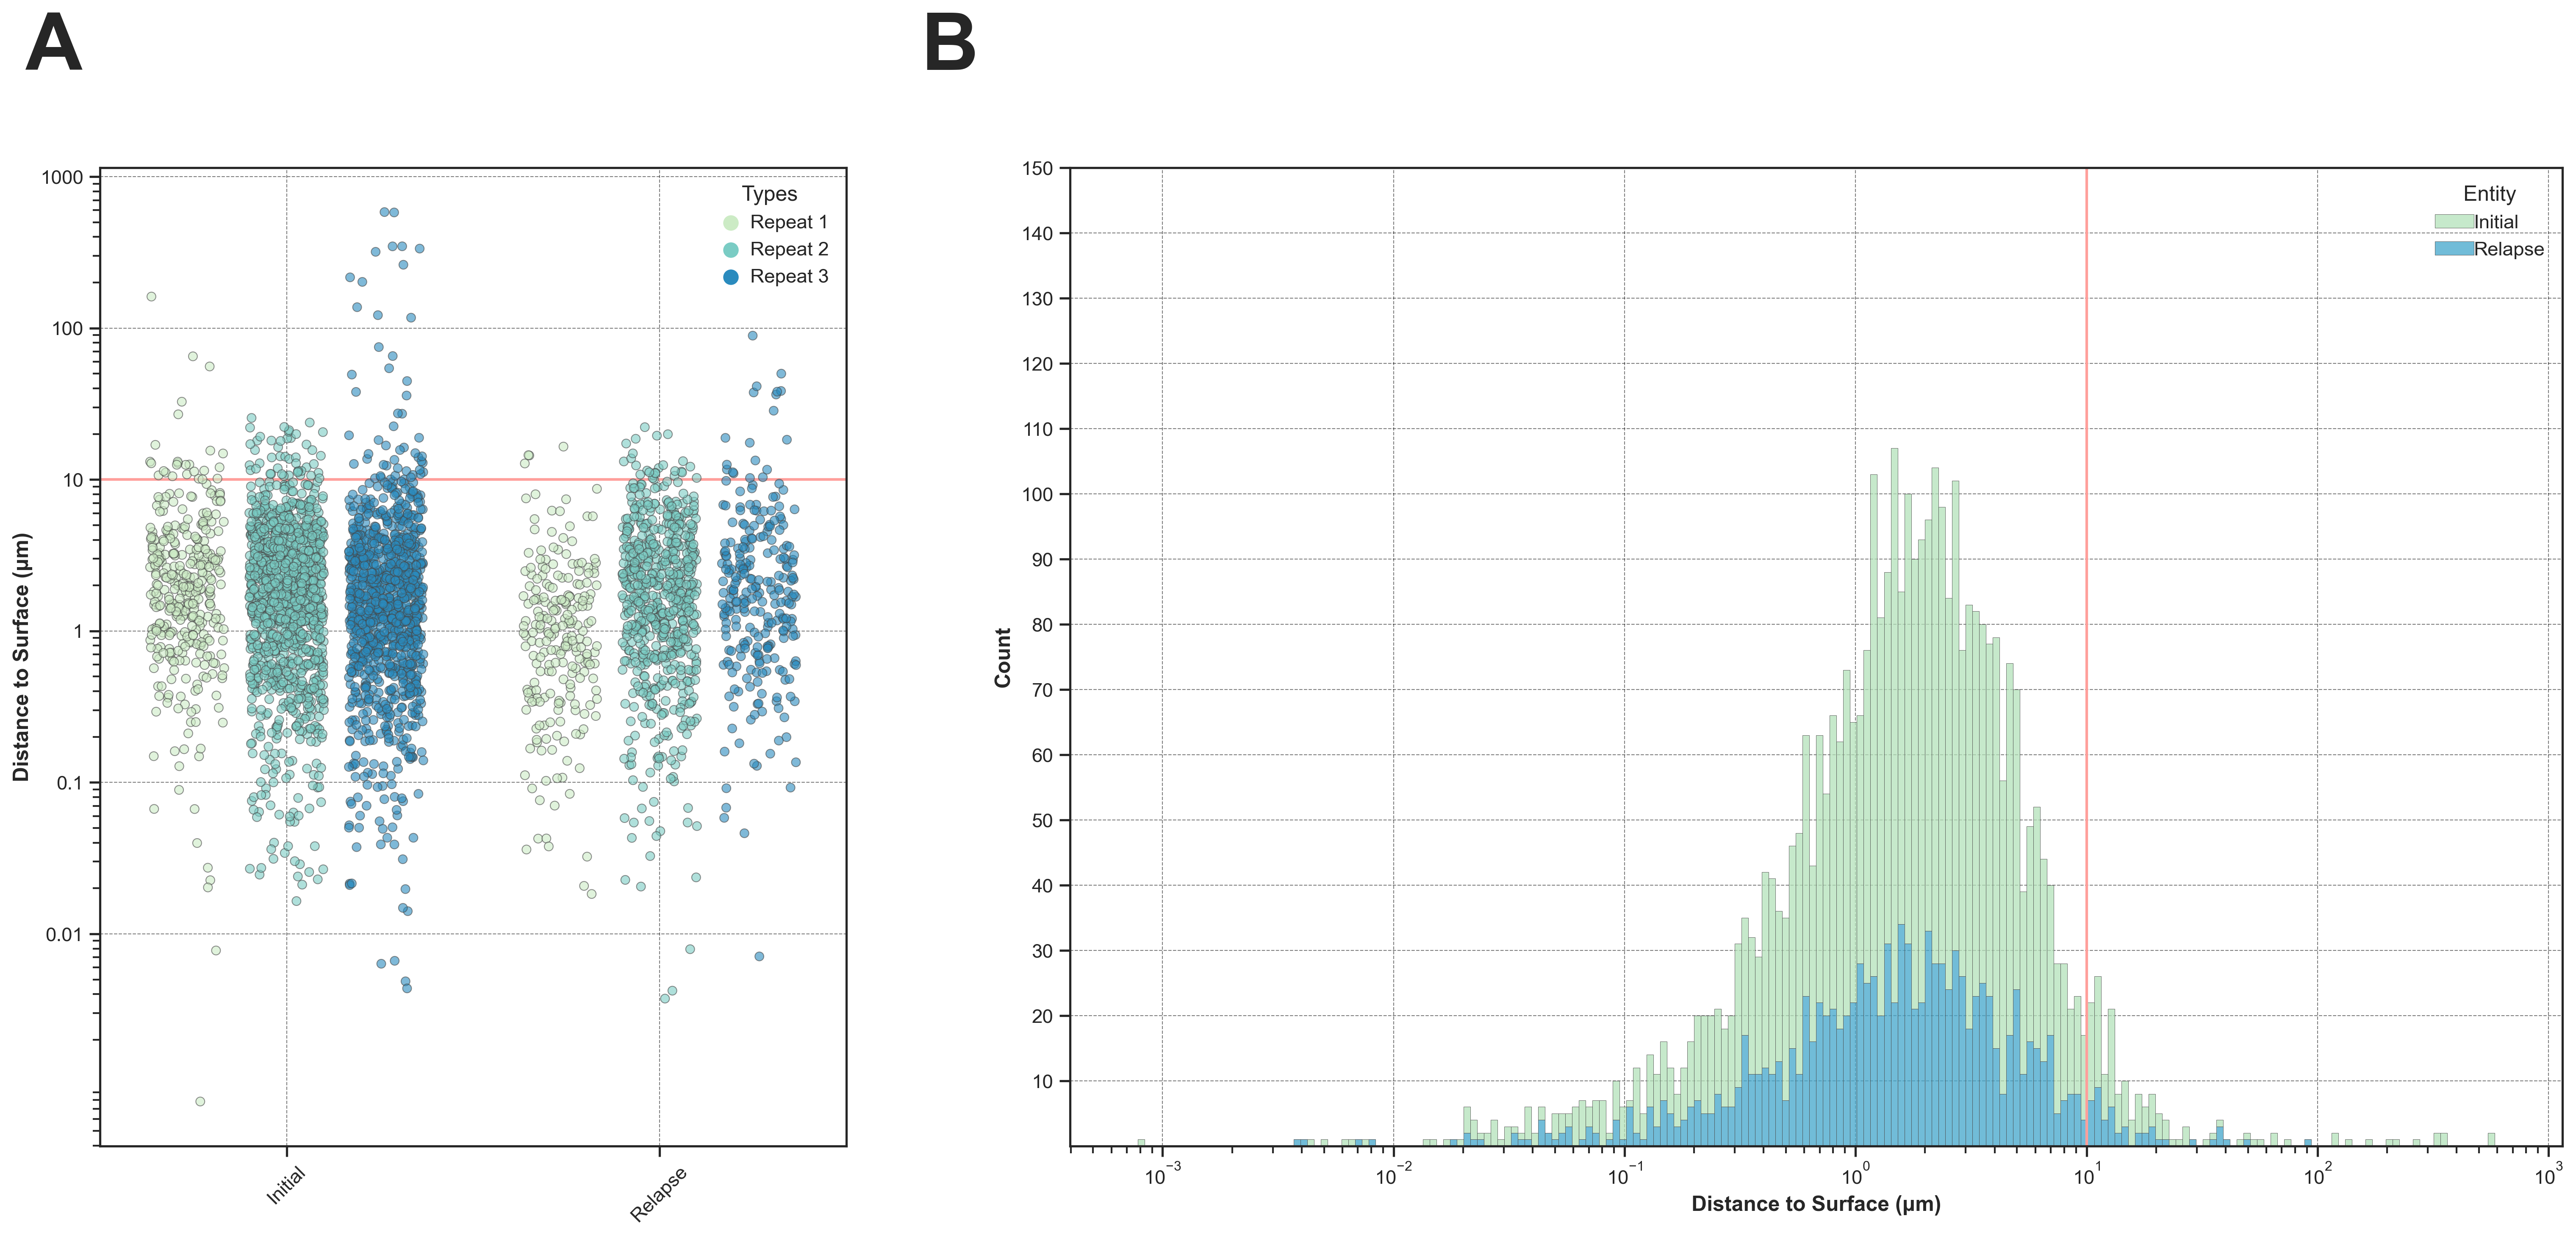

In [12]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 2]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')

texts = ['A', 'B']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

plt.savefig(plot_savepath('Initial_Relapse.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('Initial_Relapse.png'), dpi=300, bbox_inches='tight')

plt.show()

In [10]:
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False) #works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(plot_savepath('1857.png'), do_render=True)
#vis.destroy_window()